In [1]:
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import Boundary_Functions as bf
import timeit

from scipy import stats
from scipy import optimize

#import warnings
#warnings.filterwarnings("ignore")

start = timeit.default_timer()

In [2]:
rnp=np.load('rnp.npy')
signp=np.load('sig.npy')
phinp=np.load('phi.npy')
massnp=np.load('mass.npy')
rnputil=np.load('rnputil.npy')
urange=np.load('urange.npy')
vrange=np.load('vrange.npy')

In [3]:
print(rnputil)

N=int(rnputil[0])
Nu=int(rnputil[1])-1
Nv=int(rnputil[2])
ru0=float(rnputil[3])
dr0v=float(rnputil[4])
M0=float(rnputil[5])
Q=float(rnputil[6])
Lambda=float(rnputil[7])
umax=Nu/N
vmax=Nv/N

print('N='+str(N))

if M0>0.0:
    du0=M0/N
    dv0=du0
else:
    du0=1/N
    dv0=du0

def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.687,1.3,50.0],args=(M0,Q,Lambda), method='hybr')
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]
    
numpoints=Nu*Nv
print(str(numpoints)+" points")

if Q==0.0:
    predtime=numpoints/(144935)
if Q>0.0:
    predtime=numpoints/(259000)
print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")

[  5.00000000e+00   3.75600000e+03   5.00000000e+03   5.00000000e+00
   4.00000000e-01   1.00000000e+00   9.50000000e-01   0.00000000e+00]
N=5
18775000 points
Runtime: about 1.21 minutes


In [4]:
print(massnp[50][-10])
print(massnp[1000][75])

print(np.nanmean(massnp))

1.00055209395
1.00043265573
4.55275935784e+272


C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\matplotlib\contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


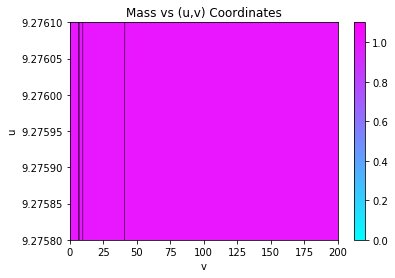

In [5]:
masslist=[1.0,1.00001,1.0001,1.001,1.01]

plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(massnp),cmap=plt.cm.cool,vmin=0.0,vmax=1.1)
plot4=plt.contour(vrange,urange,np.ma.masked_invalid(massnp), masslist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, masslist,  
           inline=0, inline_spacing=0, 
           fmt='%1.6f',rightside_up=True,
           fontsize=8)
plt.xlabel('v')
plt.ylabel('u')
#plt.xlim(0,vmax)
#plt.ylim(0,13)
plt.xlim(0,200)
plt.ylim(9.2758,9.2761)
plt.colorbar(plot1)
plt.title('Mass vs (u,v) Coordinates')
plt.show()

In [6]:
print(Nu)
print(Nv)
print(urange[500])

3755
5000
9.27655314815


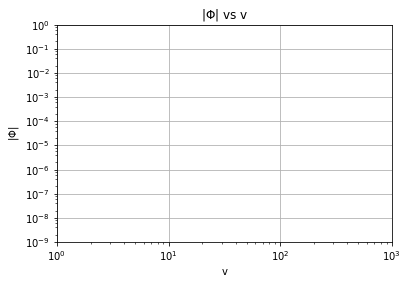

C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


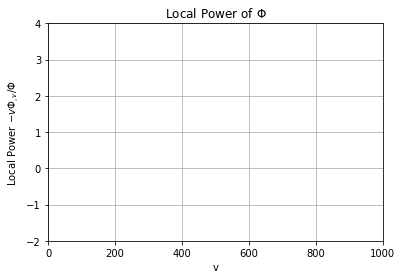

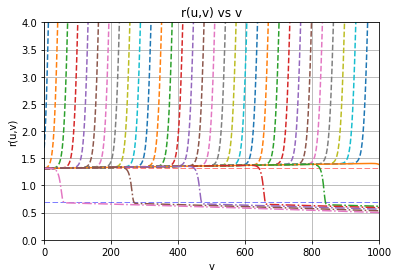

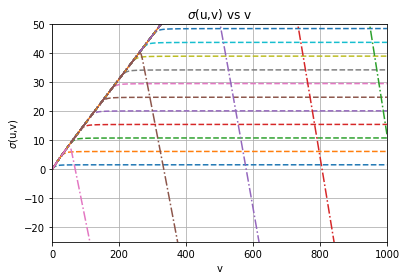

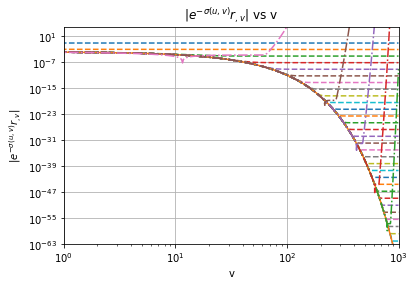

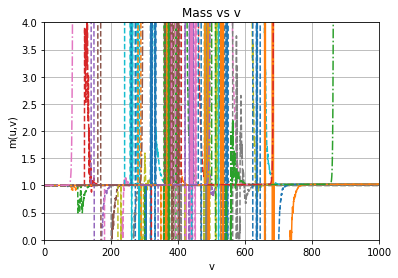

In [32]:
#uEH=5.0/umax

#uN2u=13

#uN2=int(uN2u/umax*Nu)
uNEH=3167
ustep=100
uN1=uNEH-3100
#uNmax

#print(uN2)
localpowerlist=np.zeros((Nv))*np.nan
etemplist=np.zeros((Nv))*np.nan
power1list=[]
power3list=[]




#for j in range(0,Nv-1):
    #v=j*vmax/(Nv)
    #localpowerlist[j]=-v*(phinp[uN2][j+1]-phinp[uN2][j])/(dv0*phinp[uN2][j])
    
uN=uN1
while uN < Nu:
    #print(uN)
    if uN<uNEH:
        sample3=plt.plot(vrange,abs(phinp[uN]),'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,abs(phinp[uN]))
    if uN>uNEH:
        sample3=plt.plot(vrange,abs(phinp[uN]),'-.')
    #sample3=plt.plot(vrange,abs(phinp[uN1+uN]))
    uN+=ustep
    
plt.xlabel('v')
plt.ylabel(r'$|\Phi|$')
plt.ylim(0.000000001,1.0)
plt.xlim(1,vmax)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title(r'$|\Phi|$ vs v')
plt.savefig('PhiEHLambda.png',dpi=300,bbox_inches="tight")
plt.show()    

#sample3=plt.plot(vrange,localpowerlist)
uN=uN1
while uN< Nu:
    for j in range(0,Nv-1):
        v=j*vmax/(Nv)
        localpowerlist[j]=-v*(phinp[uN][j+1]-phinp[uN][j])/(dv0*phinp[uN][j])
    
    if uN<uNEH:
        sample3=plt.plot(vrange,localpowerlist,'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,localpowerlist)
    if uN>uNEH:
        sample3=plt.plot(vrange,localpowerlist,'-.')
    #sample3=plt.plot(vrange,localpowerlist)+
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'Local Power $-v \Phi_{,v}/\Phi$')
plt.ylim(-2,4)
plt.grid()
plt.title(r'Local Power of $\Phi$') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('PhipowerEHLambda.png',dpi=300,bbox_inches="tight")
plt.show()

uN=uN1
plt.plot([0,vmax],[rplus,rplus],'r--',color='red',linewidth=0.5)
plt.plot([0,vmax],[rminus,rminus],'r--',color='blue',linewidth=0.5)
while uN< Nu:
    if uN<uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,rnp[uN,:])
    if uN>uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'-.')
    #sample3=plt.plot(vrange,rnp[uN1+uN,:])
    uN+=ustep
    
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel('r(u,v)')
plt.ylim(0,4)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.title('r(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('rEHLambda.png',dpi=300,bbox_inches="tight")
plt.show()

uN=uN1
while uN< Nu:
    if uN<uNEH:
        sample3=plt.plot(vrange,signp[uN,:],'--',label='u='+str(uN))
    if uN==uNEH:
        sample3=plt.plot(vrange,signp[uN,:])
    if uN>uNEH:
        sample3=plt.plot(vrange,signp[uN,:],'-.')
    #sample3=plt.plot(vrange,signp[uN1+uN,:])
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'$\sigma$(u,v)')
plt.ylim(-25,50)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.title(r'$\sigma$(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('sigEHLambda.png',dpi=300,bbox_inches="tight")
plt.show()
#print(localpowerlist[-200])

uN=uN1
while uN< Nu:
    for j in range(0,Nv-1):
          etemplist[j]=abs(mth.exp(-signp[uN,j])*(rnp[uN,j+1]-rnp[uN,j])/dv0)
    if uN<uNEH:
        sample3=plt.plot(vrange,etemplist,'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,etemplist)
    if uN>uNEH:
        sample3=plt.plot(vrange,etemplist,'-.')
    #print(etemplist)
    uN+=ustep
plt.xlim(1,vmax)
plt.ylim(10**(-63),10000)
plt.xlabel('v')
plt.ylabel(r'|$e^{-\sigma(u,v)} r_{,v}$|')
#plt.ylim(2,4)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title(r'|$e^{-\sigma(u,v)} r_{,v}$| vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('weirdEHLambda.png',dpi=300,bbox_inches="tight")
plt.show()


uN=uN1
while uN< Nu:
    if uN<uNEH:
        sample3=plt.plot(vrange,massnp[uN,:],'--')
    if uN==uNEH:
        sample3=plt.plot(vrange,massnp[uN,:])
    if uN>uNEH:
        sample3=plt.plot(vrange,massnp[uN,:],'-.')
    #sample3=plt.plot(vrange,rnp[uN1+uN,:])
    uN+=ustep
    
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel('m(u,v)')
plt.ylim(0,4)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()
plt.title('Mass vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
#plt.savefig('rEHfull.png',dpi=300,bbox_inches="tight")
plt.show()


LinregressResult(slope=-0.00055018029076375535, intercept=0.093129902163925055, rvalue=-0.99396981910046267, pvalue=0.0, stderr=1.108512199949947e-06)
[ nan  nan]


C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: divide by zero encountered in log
C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log


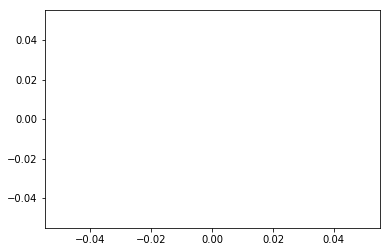

In [8]:
v1=int(300/vmax*Nv)#2000
v2=int(900/vmax*Nv)#3000

print(stats.linregress(vrange[v1:v2],localpowerlist[v1:v2]))
#print(stats.linregress(vrange[2000:4000],phinp[uN2][2000:4000]))

print(np.polyfit(np.log(vrange[v1:v2]),np.log(phinp[uNEH][v1:v2]),1.0))
plt.plot(np.log(vrange[v1:v2]),np.log(phinp[uNEH][v1:v2]))
plt.show()



In [9]:
localpowerv=np.zeros((Nu,Nv))*np.nan

for i in range(0,Nu-1):
    for j in range(0,Nv-1):
        v=j*vmax/(Nv)
        localpowerv[i][j]=-v*(phinp[i][j+1]-phinp[i][j])/(dv0*phinp[i][j])
        

C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


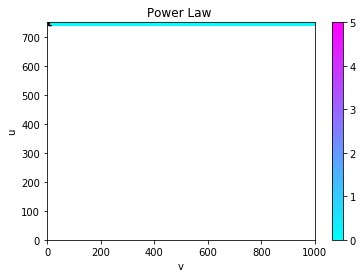

In [10]:
powerlist=[1,2,3,4,5]

#plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(localpowerv),cmap=plt.cm.cool,vmin=0.0,vmax=5.0)
#plot4=plt.contour(vrange,urange,np.ma.masked_invalid(localpowerv), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')

plot1=plt.imshow(np.ma.masked_invalid(localpowerv),cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower',vmin=0.0,vmax=5.0)
plot4=plt.contour(np.ma.masked_invalid(localpowerv), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')

plt.clabel(plot4, powerlist,inline=0, inline_spacing=0, fmt='%1.6f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
#plt.xlim(0,400)
#plt.ylim(9.36,9.37)
#plt.ylim(0,1000)
plt.colorbar(plot1)
plt.title('Power Law ')
#plt.savefig('RN-err-max-N_60.png',dpi=300)
plt.show()

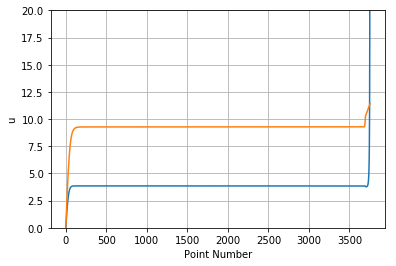

In [11]:
ueddrange=np.empty((Nu))
ueddrange[0]=0.0
M=massnp[1][-1]

for i in range(0,Nu-1):
    
    #print(M)
    ueddrange[i+1]=ueddrange[i]+(urange[i+1]-urange[i])*(1-2*M/rnp[i][0]+Q**2/rnp[i][0]**2)**(1)*mth.exp(-signp[i][0])
    
plt.plot(ueddrange)
plt.plot(urange)
plt.ylim(0,20)
plt.xlabel('Point Number')
plt.ylabel('u')
plt.grid()
plt.show()



In [12]:
localpoweru=np.zeros((Nu,Nv))*np.nan

for i in range(0,Nu-1):
    for j in range(0,Nv-1):
        #u=i*umax/(Nu)
        #=urange[i]
        u=ueddrange[i]
        try:
            localpoweru[i][j]=-u*(phinp[i+1][j]-phinp[i][j])/(du0*phinp[i][j])#*(1-2*massnp[i][j]/rnp[i][j]+Q**2/rnp[i][j]**2)**(-1)*mth.exp(signp[i][j])
        except:
            localpoweru[i][j]=np.nan

C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Brandon\Downloads\WinPython-64bit-3.6.1.0Qt5\python-3.6.1.amd64\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in double_scalars


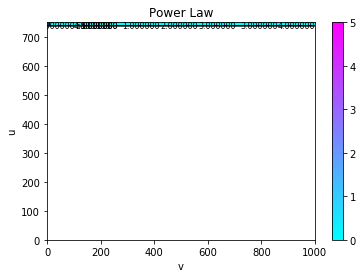

In [13]:
powerlist=[1,2,3,4,5]

#plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(localpoweru),cmap=plt.cm.cool,vmin=0.0,vmax=10.0)
#plot4=plt.contour(vrange,urange,np.ma.masked_invalid(localpoweru), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')


plot1=plt.imshow(np.ma.masked_invalid(localpoweru),cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower',vmin=0.0,vmax=5.0)
plot4=plt.contour(np.ma.masked_invalid(localpoweru), powerlist,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')

plt.clabel(plot4, powerlist,inline=0, inline_spacing=0, fmt='%1.6f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim(0,vmax)
#plt.ylim(9.0,10.8)
plt.colorbar(plot1)
plt.title('Power Law')
#plt.savefig('RN-err-max-N_60.png',dpi=300)
plt.show()

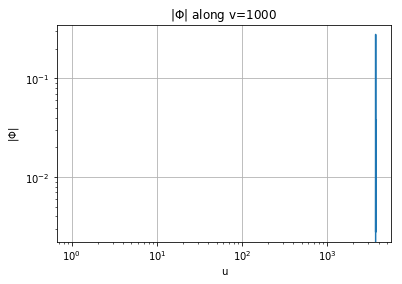

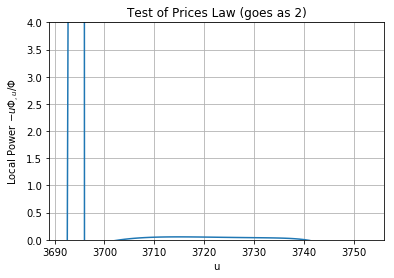

In [14]:
sample3=plt.plot(abs(phinp[:,-1]))
plt.xlabel('u')
plt.ylabel(r'$|\Phi|$')
#plt.ylim(0.0000000001,0.001)
#plt.xlim(18.2999,18.299905)
#plt.xlim(0.,100)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title(r'$|\Phi|$ along v=1000')
plt.savefig('Phi1.png',dpi=300,bbox_inches="tight")
plt.show()  


sample3=plt.plot(localpoweru[:,-2])
#plt.xlim(0,1000)
plt.xlabel('u')
plt.ylabel(r'Local Power $-u \Phi_{,u}/\Phi$')
plt.ylim(0,4)
#plt.xlim(11,20)
plt.grid()
plt.title('Test of Prices Law (goes as 2)')
plt.savefig('Phi2.png',dpi=300,bbox_inches="tight")
plt.show()

In [15]:
stop = timeit.default_timer()

In [16]:
acttime=stop - start

print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str((numpoints)/(stop - start))+' points per second') 

exttime=format((acttime-predtime)/60,'.2f')

print("Took "+str(exttime)+" more minutes")

113.69008695965947 seconds
1.894834782660991 minutes
0.03158057971101652 hours
165141.92663659333 points per second
Took 0.69 more minutes


In [17]:
uc=1000
vc=-10
print(2.0/1.75)
print((1-2*massnp[uc][vc]/rnp[uc][vc]+Q**2/rnp[uc][vc]**2)**(-1)*mth.exp(-signp[uc][vc]))
print((1-2*massnp[uc][vc]/rnp[uc][vc]+Q**2/rnp[uc][vc]**2)**(-1)*mth.exp(-signp[uc][vc]))
print(massnp[uc][vc])
print(uc*umax/Nu)
print(mth.exp(-signp[uc][vc]))


1.1428571428571428
2.01307596474e-20
2.01307596474e-20
1.00771174452
200.0
1.9984509856395314e-20


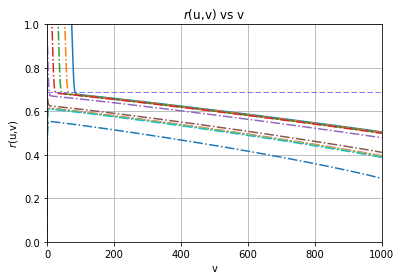

In [18]:
uNEH=Nu-100
ustep=10
uN1=uNEH#uNEH-3000
Numax=Nu+1

plt.plot([0,vmax],[rplus,rplus],'r--',color='red',linewidth=0.5, label='r+')
plt.plot([0,vmax],[rminus,rminus],'r--',color='blue',linewidth=0.5, label='r-')

uN=uN1
while uN< Numax:
    if uN<uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'--',label='u='+str(urange[uN]))
    if uN==uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],label='u='+str(urange[uN]))
    if uN>uNEH:
        sample3=plt.plot(vrange,rnp[uN,:],'-.',label='u='+str(urange[uN]))
    #sample3=plt.plot(vrange,signp[uN1+uN,:])
    uN+=ustep
plt.xlim(0,vmax)
plt.xlabel('v')
plt.ylabel(r'$r$(u,v)')
plt.ylim(0,1.0)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.grid()
plt.title(r'$r$(u,v) vs v') #(u='+str(uN2u)+')')#+',uEH='+str(uEH*umax)+')')
plt.savefig('near_r_0.png',dpi=300,bbox_inches="tight")
plt.show()